This script borrows ideas from the notebook created by 'juliencs' (https://www.kaggle.com/juliencs) in https://www.kaggle.com/. The link for the notebook is given below:

https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from scipy.stats import skew

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
plt.style.use('ggplot')

In [3]:
# Load train data
train_df = pd.read_csv('dataset/kaggle-house-price/train.csv')
test_df = pd.read_csv('dataset/kaggle-house-price/test.csv')
print train_df.shape
train_df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Check for duplicate Ids
num_duplicates = len(train_df['Id'].unique()) - train_df['Id'].size
print "There are %d duplicate Ids in the training dataset." % num_duplicates

# Set Id as index
train_df.set_index('Id', drop=True, inplace=True)
test_df.set_index('Id', drop=True, inplace=True)
train_df.head()

There are 0 duplicate Ids in the training dataset.


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Preprocessing

In [5]:
numeric_data = train_df.select_dtypes(include=['int', 'float'])
numeric_data.columns

Index([u'MSSubClass', u'LotFrontage', u'LotArea', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea',
       u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces', u'GarageYrBlt',
       u'GarageCars', u'GarageArea', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal',
       u'MoSold', u'YrSold', u'SalePrice'],
      dtype='object')

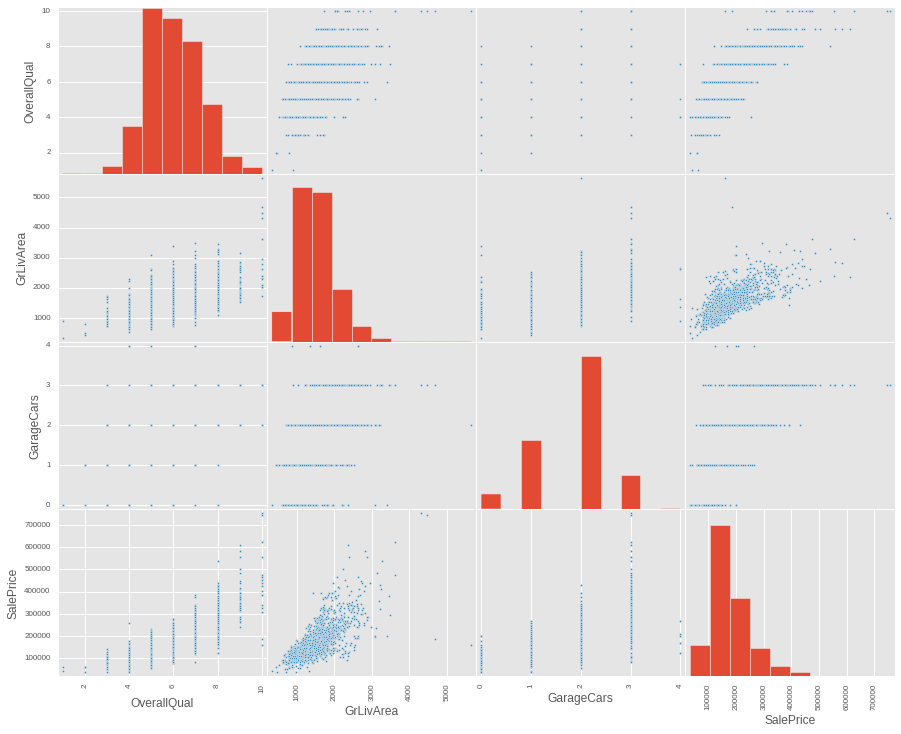

In [6]:
# Trying to find outliers

features = ['OverallQual', 'GrLivArea', 'GarageCars', 'SalePrice']
scatter_matrix(numeric_data[features], alpha=1, figsize=(15,12));
plt.show()

There are two outliers in SalePrice vs GrLivArea graph, i.e two really big houses are sold for very less price. These two house can be considered as special conditions and is safe to remove from the training dataset.

**NOTE**: Outliers can affect the prediction adversely.

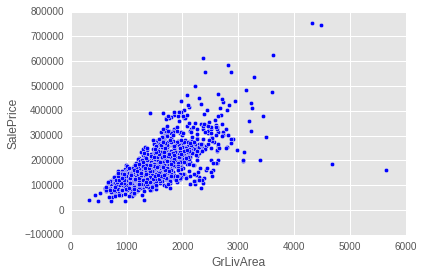

In [7]:
plt.figure(figsize=(6, 4))
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show();

In [8]:
# Removing houses with living area > 4500
train_df = train_df[train_df['GrLivArea'] < 4500]

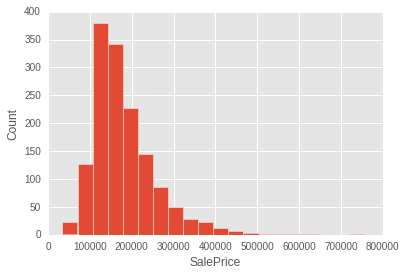

In [9]:
train_df['SalePrice'].hist(bins=20)
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.show();

From the above histogram its clear that it has a skewed distribution. Hence it is advisable to log tranform the sale price so that errors in predicting expensive houses and cheap houses will affect the result equally.

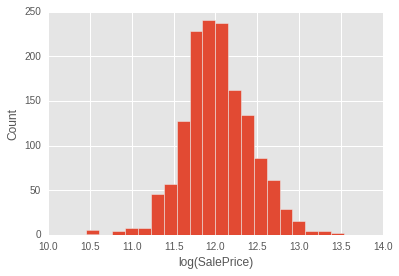

In [10]:
# Log transfrom SalePrice
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
train_df['SalePrice'].hist(bins=20)
plt.xlabel('log(SalePrice)')
plt.ylabel('Count')
plt.show();

### Handling missing values

In [11]:
y = train_df['SalePrice']
train_df = train_df.drop('SalePrice', axis=1)
test_df = test_df[train_df.columns]
all_data = pd.concat([train_df, test_df], axis=0)
all_data.shape

(2917, 79)

In [12]:
# null values
def null_values_per_col(df):
    """
    Returns a Pandas Series containing the number of null values for each
    column which has atleast 1 null value.
    """
    null_cols_all = df.apply(lambda x: x.size - x.count())
    null_cols = pd.Series()

    for col, val in null_cols_all.iteritems():
        if val > 0:
            null_cols[col] = val

    return null_cols

print "null values:"
null_values_per_col(all_data)

null values:


MSZoning           4
LotFrontage      486
Alley           2719
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2908
Fence           2346
MiscFeature     2812
SaleType           1
dtype: int64

In [13]:
def fill_cols_with_val(df, cols, val):
    """
    Fill the columns specified in the DataFrame df with val
    """
    df[cols] = df[cols].fillna(val)

In [14]:
# fill with 'NA' wherever applicable
NA_cols = ['Alley', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'BsmtFinType2',
           'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual']

fill_cols_with_val(all_data, NA_cols, 'NA')

# fill with zero wherever applicable
zero_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath',
             'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF']

fill_cols_with_val(all_data, zero_cols, 0)

# fill with mode wherever applicable
mode_cols = ['Exterior1st', 'Exterior2nd', 'Electrical', 'Functional', 'KitchenQual',
             'MSZoning', 'SaleType', 'Utilities']

for col in mode_cols:
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)

all_data['MasVnrType'].fillna('None', inplace=True)
all_data['LotFrontage'].fillna(all_data['LotFrontage'].mean(), inplace=True)

null_values_per_col(all_data)

GarageYrBlt    159
dtype: int64

In [15]:
# Remove GarageYrBlt from dataset
all_data.drop('GarageYrBlt', axis=1, inplace=True)

### Encode categories

In [16]:
# Some numerical features are actually categories.
# Converting them to string
all_data[['MSSubClass', 'MoSold']] = all_data[['MSSubClass', 'MoSold']].astype(str)

In [17]:
# Split train dataset into numerical and categorical types
numerical_feats = all_data.select_dtypes(exclude=['object']).columns
categorical_feats = all_data.select_dtypes(include=['object']).columns
data_num = all_data[numerical_feats]
data_cat = all_data[categorical_feats]
# Encode categories
data_cat = pd.get_dummies(data_cat)

### Check for skewness

In [18]:
skewed_vars = data_num.apply(lambda x: skew(x))

# Skewness > 0.5 is log tranformed
skewed_vars = skewed_vars[abs(skewed_vars) > 0.5]
data_num[skewed_vars.index] = np.log1p(data_num[skewed_vars.index])

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


### Split into train and test set

In [19]:
# Join numerical and categorical variables
all_data = pd.concat([data_cat, data_num], axis=1)
train = all_data.loc[train_df.index]
test = all_data.loc[test_df.index]

# Split into training and cross validation set
X_train, X_cv, y_train, y_cv = train_test_split(train, y, test_size=0.3, random_state = 7)
print X_train.shape
print X_cv.shape

(1020, 326)
(438, 326)


### Scaling

In [20]:
stdScaler = StandardScaler()
X_train.loc[:, numerical_feats] = stdScaler.fit_transform(X_train.loc[:, numerical_feats])
X_cv.loc[:, numerical_feats] = stdScaler.fit_transform(X_cv.loc[:, numerical_feats])
test.loc[:, numerical_feats] = stdScaler.fit_transform(test.loc[:, numerical_feats])

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Standardization cannot be done before partitioning, as we don't want to fit the StandardScaler on some observations that will later be used in the test set.

In [21]:
# Error measure
def rmse_cv(model, X, y, cv=10):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv))
    return rmse

### Linear Regression without regularization

RMSE on training set is : 16294436039.7
RMSE on test set is : 70183622120.8


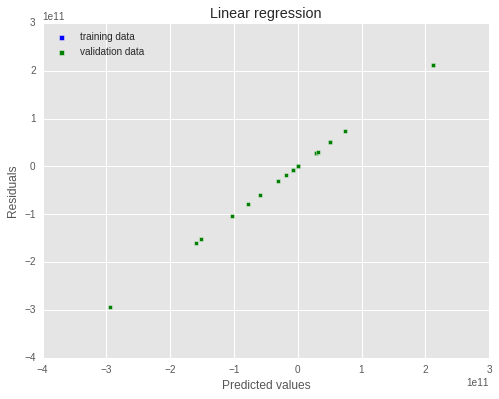

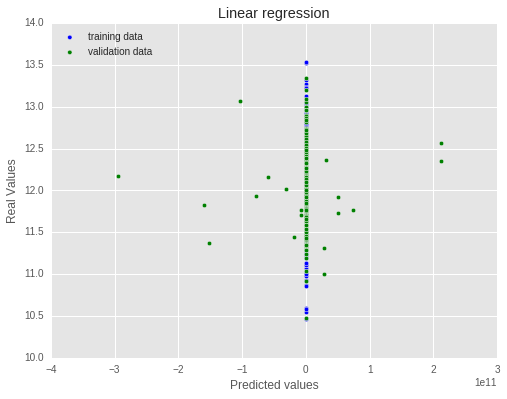

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# RMSE on train and cross validation set
print "RMSE on training set is :", rmse_cv(lr, X_train, y_train).mean()
print "RMSE on test set is :", rmse_cv(lr, X_cv, y_cv).mean()

y_train_pred = lr.predict(X_train)
y_cv_pred = lr.predict(X_cv)

# Function to plot residuals and predictions
def plot_residuals_and_predictions(y_train_pred, y_train, y_test_pred, y_test):
    """
    Plot the residuals and predictions as two separate graphs
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_pred, (y_train_pred - y_train), c='blue', marker='s', label='training data')
    plt.scatter(y_test_pred, (y_test_pred - y_test), c='green', marker='s', label='validation data')
    plt.title("Linear regression")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_pred, y_train, c='blue', label='training data')
    plt.scatter(y_test_pred, y_test, c='green', label='validation data')
    plt.title("Linear regression")
    plt.xlabel("Predicted values")
    plt.ylabel("Real Values")
    plt.legend(loc = "upper left")
    plt.show()

plot_residuals_and_predictions(y_train_pred, y_train, y_cv_pred, y_cv)

### Linear regression with Ridge regularization

Best alpha is 10.0
Finding better alpha value around 10.0
Best alpha is 10.0
RMSE for training set is 0.112542568205
RMSE for cv set is 0.123743091236


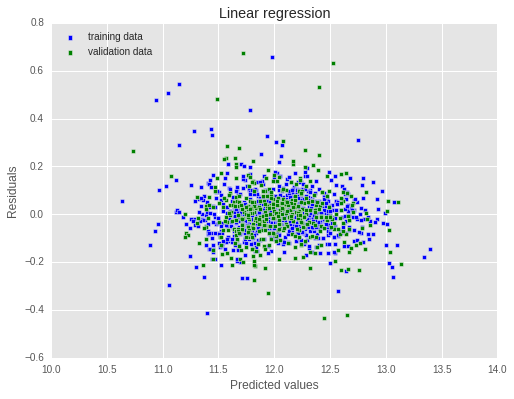

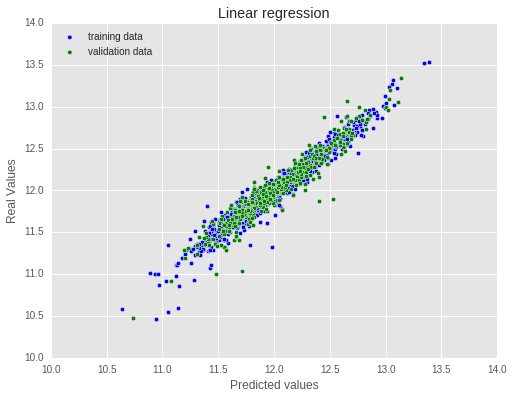

In [23]:
ridge = RidgeCV(alphas=[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print "Best alpha is", alpha
print "Finding better alpha value around", alpha

alphas = np.round(np.linspace(0.5, 1.5, 10) * alpha, 1)
ridge = RidgeCV(alphas=alphas)
ridge.fit(X_train, y_train)
print "Best alpha is", alpha

print "RMSE for training set is", rmse_cv(ridge, X_train, y_train).mean()
print "RMSE for cv set is", rmse_cv(ridge, X_cv, y_cv).mean()

y_train_pred = ridge.predict(X_train)
y_cv_pred = ridge.predict(X_cv)

plot_residuals_and_predictions(y_train_pred, y_train, y_cv_pred, y_cv)

Number of coefficients picked by RidgeCV : 315
Number of coefficients eliminated by RidgeCV : 11


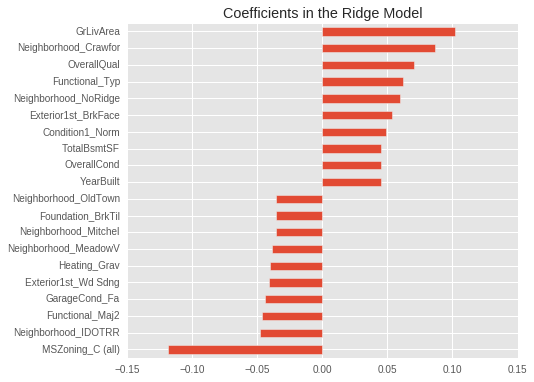

In [24]:
# Plot important coefficients
coeffs = pd.Series(ridge.coef_, index=X_train.columns)
print "Number of coefficients picked by RidgeCV :", sum(coeffs != 0)
print "Number of coefficients eliminated by RidgeCV :", sum(coeffs == 0)
ridge_coeffs = coeffs.sort_values()
important_coeffs = pd.concat([ridge_coeffs.head(10), ridge_coeffs.tail(10)])
plt.figure(figsize=(7, 6))
important_coeffs.plot(kind='barh')
plt.title("Coefficients in the Ridge Model")
plt.show();

In [25]:
test_pred = np.expm1(ridge.predict(test))
solution = pd.DataFrame({'SalePrice': test_pred}, index=test_df.index)
solution.to_csv('outputs/ridge-regression-solution.csv')

### Linear regression with Lasso regularization

Best alpha is 0.0006
Finding better alpha value around 0.0006
Best alpha is 0.000433
RMSE for training set is 0.109293105131
RMSE for cv set is 0.124474351281


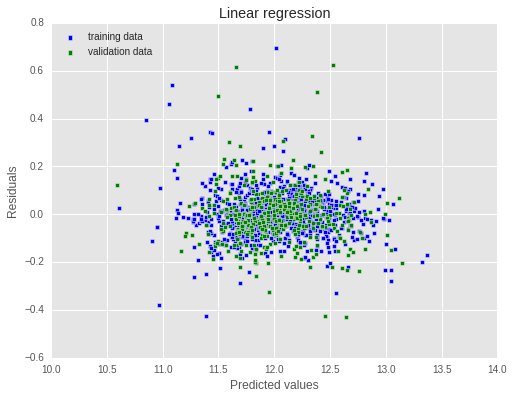

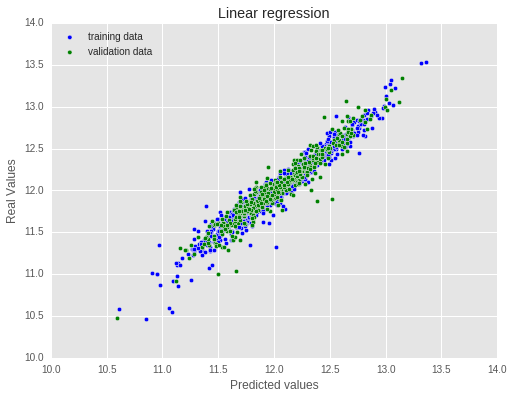

In [26]:
lasso = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
                max_iter=50000, cv=10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print "Best alpha is", alpha
print "Finding better alpha value around", alpha

alphas = np.round(np.linspace(0.5, 1.5, 10) * alpha, 6)
lasso = LassoCV(alphas=alphas, max_iter=60000, cv=10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print "Best alpha is", alpha

print "RMSE for training set is", rmse_cv(lasso, X_train, y_train).mean()
print "RMSE for cv set is", rmse_cv(lasso, X_cv, y_cv).mean()

y_train_pred = lasso.predict(X_train)
y_cv_pred = lasso.predict(X_cv)

plot_residuals_and_predictions(y_train_pred, y_train, y_cv_pred, y_cv)

Number of coefficients picked by LassoCV : 122
Number of coefficients eliminated by LassoCV : 204


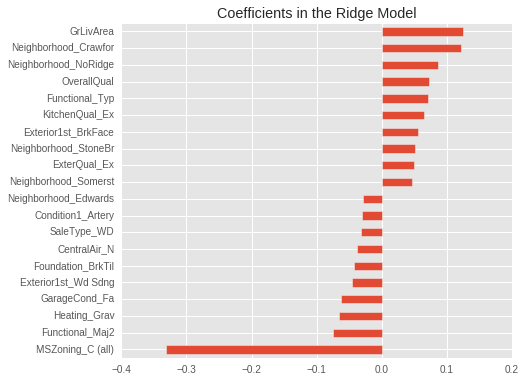

In [27]:
# Plot important coefficients
coeffs = pd.Series(lasso.coef_, index=X_train.columns)
print "Number of coefficients picked by LassoCV :", sum(coeffs != 0)
print "Number of coefficients eliminated by LassoCV :", sum(coeffs == 0)
coeffs = coeffs.sort_values()
important_coeffs = pd.concat([coeffs.head(10), coeffs.tail(10)])
plt.figure(figsize=(7, 6))
important_coeffs.plot(kind='barh')
plt.title("Coefficients in the Ridge Model")
plt.show();

In [28]:
test_pred = np.expm1(lasso.predict(test))
solution = pd.DataFrame({'SalePrice': test_pred}, index=test_df.index)
solution.to_csv('outputs/lasso-regression-solution.csv')